# ResNet18 implementation

ResNet paper:
https://arxiv.org/pdf/1512.03385.pdf

The implementation details of ResNet18 are listed in Table 1 of the paper.



In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
from torch import Tensor
from typing import Type

In [2]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.dropout1 = nn.Dropout(0.05)
        self.dropout2 = nn.Dropout(0.05)
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout2(out)
        return  out

In [3]:
class ResNet18(nn.Module):
    def __init__(self, img_channels = 3, block: Type[BasicBlock] = BasicBlock, num_classes = 400):
        super(ResNet18, self).__init__()
        # Implement ResNet18.
        # Structure listed in https://arxiv.org/pdf/1512.03385.pdf - Table 1
        self.in_channels = 64
        # The fixed initial few layers
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual block layers
        self.layer1 = self._make_layer(block, 64, 2)
        self.layer2 = self._make_layer(block, 128, 2, stride=2)
        self.layer3 = self._make_layer(block, 256, 2, stride=2)
        self.layer4 = self._make_layer(block, 512, 2, stride=2)

        # Last layers = avg. pooling -> flatten -> fc
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1: # for res block layers 2-4
            # downsampling to have same dimensions for the shortcut so we can add them up
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # The spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        #print('Dimensions of the last convolutional feature map: ', x.shape)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Networks in PyTorch can be defined as in the example below:

In [2]:
class ExampleNet(nn.Module):
    def __init__(self):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2,stride=2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2,stride=2)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.fc_out = nn.Linear(128,400)

    def forward(self, x):
        c1 = self.conv1(x)
        bn1 = self.batchnorm1(c1)
        a1 = nn.functional.relu(bn1)
        p1 = self.pool1(a1)

        c2 = self.conv2(p1)
        bn2 = self.batchnorm2(c2)
        a2 = nn.functional.relu(bn2)
        p2 = self.pool2(a2)

        c3 = self.conv3(p2)
        bn3 = self.batchnorm3(c3)
        a3 = nn.functional.relu(bn3)
        p3 = self.pool3(a3)

        c4 = self.conv4(p3)
        bn4 = self.batchnorm4(c4)
        a4 = nn.functional.relu(bn4)
        # Take the global average of each channel
        global_avg = torch.mean(a4, dim=[2,3])
        out = self.fc_out(global_avg)
        return out

# Loading the data

We will use a bird dataset, where the task is to classify each image into one of 400 different classes of birds.

## Download the data

In [4]:
!pip install --upgrade --no-cache-dir gdown
!gdown  --id 1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1
!unzip -q bird_data.zip

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1
From (redirected): https://drive.google.com/uc?id=1ZjdZigcUnMxT_KG5P0GVolQ9y-7wgZM1&confirm=t&uuid=c8b8c229-79b2-4974-8004-04cf5468c9ad
To: /content/bird_data.zip
100% 1.40G/1.40G [00:30<00:00, 46.5MB/s]


## Data Loader

* PyTorch typically uses Dataset and DataLoader classes to load data during training. The DataLoader enables processing data on multiple cores (num_workers argument), which is useful as the data loading speed is commonly the bottleneck in network training.

* The batch size used during training is also usually an argument of the DataLoader.

* We will be using the torchvision.datasets.ImageFolder class that can easily load images that have been separated into individual folders by class. The data loader then outputs the data in the form of (image, label) pairs. For tasks other than classification, custom dataset classes are more common.

In [5]:
import torchvision
import torch
import torchvision.transforms as transforms

batch_size = 256
# Transforms can also be used for image augmentation - https://pytorch.org/vision/stable/transforms.html
transform = transforms.Compose(
    [
    transforms.ToTensor()
    ])

transform_test = transforms.Compose(
    [transforms.ToTensor()
    ])


trainset = torchvision.datasets.ImageFolder(root='./bird_data/train/',transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./bird_data/test/', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

valset = torchvision.datasets.ImageFolder(root='./bird_data/valid/',transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


# Displaying random trainset images
import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 5
rows = 4
for i in range(columns*rows):
  input, label = trainset[np.random.randint(len(trainset))]
  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  ax.set_title(trainset.classes[label], fontstyle='italic')
  plt.imshow(img)
plt.show()



Output hidden; open in https://colab.research.google.com to view.

## Training the network

The training parameters (learning rate, batch size, optimizer choice etc.) are not fine-tuned. Feel free to optimize the parameters further to improve the results.

In [6]:
import torch.optim as optim
from tqdm import tqdm

def test_bird_model(net, curr_data_loader, val_test="val"):
    # Testing

    criterion = nn.CrossEntropyLoss()

    num_images = len(curr_data_loader.dataset)
    gt_array = np.zeros(num_images)
    pred_array = np.zeros(num_images)

    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for i,data in enumerate(curr_data_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            gt_array[i*labels.size(0):(i+1)*labels.size(0)] = labels.detach().cpu().numpy()
            pred_array[i*labels.size(0):(i+1)*labels.size(0)] = predicted.detach().cpu().numpy()

    print('Accuracy of the network on %s images: %d %%' % (val_test,
            100 * correct / total))
    print("Test loss: "+str(running_loss/(total/4)))
    return gt_array, pred_array

def train_bird_model(epochs, lr, decay, step_size, gamma):
    # Use the ResNet18 when implemented
    net = ResNet18()
    #net = ExampleNet()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize the optimizer
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(epochs):
        with tqdm(total=len(trainset), desc ='Epoch: '+str(epoch)+"/"+str(epochs), unit='img') as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # Get the inputs; Data is a tuple of (images, labels)
                inputs, labels = data
                # Transfer the images and labels to the GPU.
                inputs = inputs.cuda()
                labels = labels.cuda()

                # Clear the saved gradients of the previous iteration
                optimizer.zero_grad()

                outputs = net(inputs)
                # Calculate the loss value
                loss = criterion(outputs, labels)
                # Calculate the gradients using backpropagation
                loss.backward()
                # Update the weights of the network using the chosen optimizer
                optimizer.step()

                prog_bar.set_postfix(**{'loss': loss.data.cpu().detach().numpy()})
                prog_bar.update(batch_size)

        scheduler.step()

        if epoch % 5 == 0:
            net.eval()
            test_bird_model(net, valloader)
            net.train()

    net.eval()
    test_bird_model(net,testloader)

    return net




## Run training

In [7]:
net = train_bird_model(25, lr=0.001, decay=0.0001, step_size=5, gamma=0.1)

Epoch: 0/25: 58624img [04:33, 214.09img/s, loss=3.9936454]


Accuracy of the network on val images: 10 %
Test loss: 0.07719175910949708


Epoch: 1/25: 58624img [04:24, 221.87img/s, loss=2.2362318]
Epoch: 2/25: 58624img [04:23, 222.14img/s, loss=1.5803428]
Epoch: 3/25: 58624img [04:23, 222.07img/s, loss=1.9380414]
Epoch: 4/25: 58624img [04:23, 222.23img/s, loss=1.1702198]
Epoch: 5/25: 58624img [04:23, 222.21img/s, loss=1.0179986]


Accuracy of the network on val images: 88 %
Test loss: 0.007413289308547974


Epoch: 6/25: 58624img [04:23, 222.29img/s, loss=0.5777414]
Epoch: 7/25: 58624img [04:24, 221.67img/s, loss=0.5114606]
Epoch: 8/25: 58624img [04:24, 221.99img/s, loss=0.3677152]
Epoch: 9/25: 58624img [04:23, 222.20img/s, loss=0.86160487]
Epoch: 10/25: 58624img [04:23, 222.27img/s, loss=0.23045187]


Accuracy of the network on val images: 91 %
Test loss: 0.005416839778423309


Epoch: 11/25: 58624img [04:23, 222.32img/s, loss=0.57237124]
Epoch: 12/25: 58624img [04:28, 218.03img/s, loss=0.4196628]
Epoch: 13/25: 58624img [04:24, 221.29img/s, loss=0.25476867]
Epoch: 14/25: 58624img [04:23, 222.24img/s, loss=0.45162502]
Epoch: 15/25: 58624img [04:23, 222.79img/s, loss=0.64563274]


Accuracy of the network on val images: 91 %
Test loss: 0.005247516810894012


Epoch: 16/25: 58624img [04:24, 221.93img/s, loss=0.5256547]
Epoch: 17/25: 58624img [04:23, 222.66img/s, loss=0.3201434]
Epoch: 18/25: 58624img [04:22, 222.98img/s, loss=0.47167435]
Epoch: 19/25: 58624img [04:22, 223.01img/s, loss=0.25233322]
Epoch: 20/25: 58624img [04:23, 222.69img/s, loss=0.4960018]


Accuracy of the network on val images: 91 %
Test loss: 0.005200265735387802


Epoch: 21/25: 58624img [04:22, 223.21img/s, loss=0.52274936]
Epoch: 22/25: 58624img [04:23, 222.61img/s, loss=0.21839468]
Epoch: 23/25: 58624img [04:23, 222.06img/s, loss=0.71885383]
Epoch: 24/25: 58624img [04:23, 222.18img/s, loss=0.64379257]


Accuracy of the network on val images: 93 %
Test loss: 0.003942272394895554


## Run Test and visualize classification errors



Accuracy of the network on val images: 93 %
Test loss: 0.003942272394895554


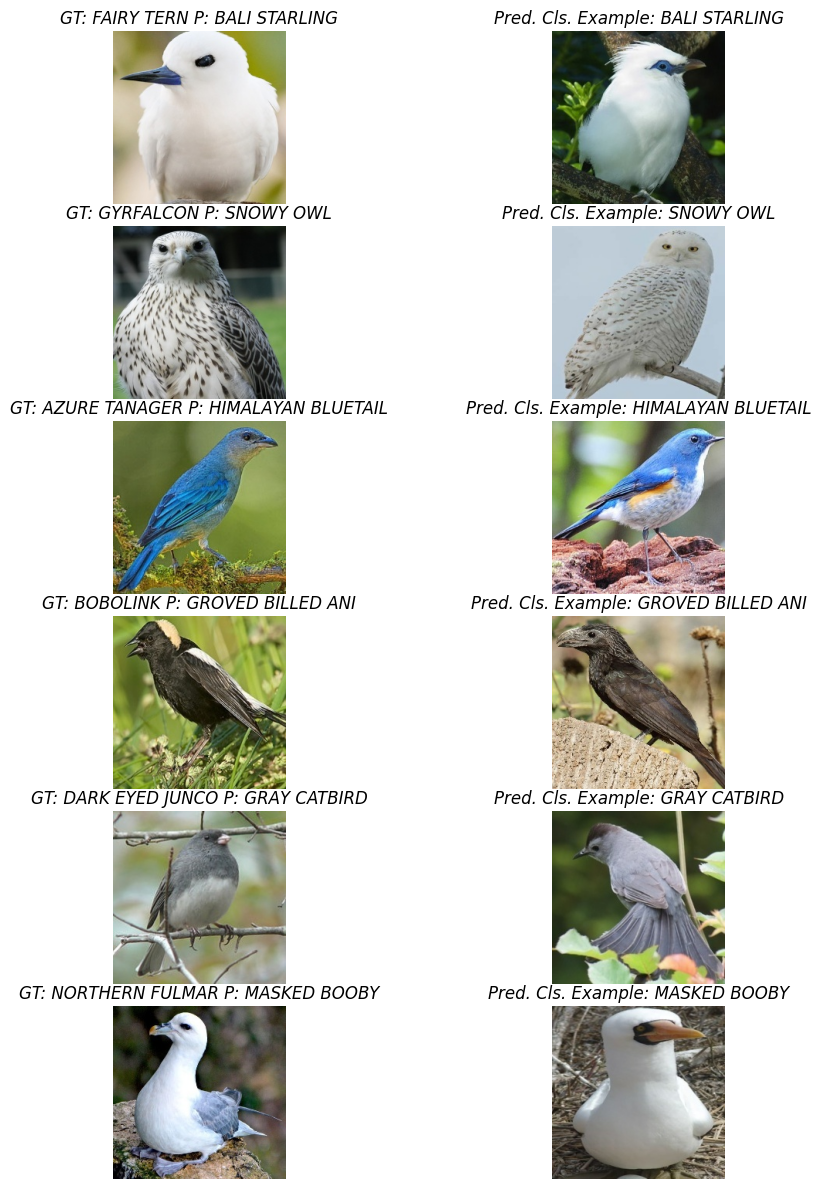

In [15]:
gt_array, pred_array = test_bird_model(net,testloader)

# Displaying random misclassified images
fig=plt.figure(figsize=(12, 12))
columns = 2
rows = 6
mistake_indices = np.nonzero(gt_array != pred_array)[0]
for i in range(rows):
  chosen_index = mistake_indices[np.random.randint(len(mistake_indices))]
  input, label = testset[chosen_index]
  pred_label = pred_array[chosen_index].astype(np.int32)
  pred_cls_samples = np.nonzero(gt_array == pred_label)[0]
  pred_cls_input, _ = testset[pred_cls_samples[np.random.randint(len(pred_cls_samples))]]


  img = input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+1)
  im_title = "GT: "+trainset.classes[label] + " P: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.axis('off')
  plt.imshow(img)

  img_sample = pred_cls_input.detach().numpy().transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, columns*i+2)
  im_title = "Pred. Cls. Example: "+trainset.classes[pred_label]
  ax.set_title(im_title, fontstyle='italic')
  plt.axis('off')
  plt.imshow(img_sample)

plt.tight_layout(h_pad=0, w_pad=0)
plt.show()
